In [38]:
from dm_control import suite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import clone_model
import random
import time
import numpy as np
from matplotlib import pyplot as plt

In [39]:
print(tf.__version__)

2.2.0


In [40]:
# Swimmer6 snake , task: get to the goal 
env = suite.load(domain_name="swimmer", task_name="swimmer6")

In [41]:
def save_models(agent):
    agent.critic_model.save('Swimmer6/critic_model.h5')
    agent.actor_model.save('Swimmer6/actor_model.h5')
    agent.target_critic_model.save('Swimmer6/target_critic_model.h5')
    agent.target_actor_model.save('Swimmer6/target_actor_model.h5')
    
def save_scores(scores,last_rewards,first_rewards):
    np.savetxt('Swimmer6/scores.csv', scores)
    np.savetxt('Swimmer6/last_rewards.csv', last_rewards)
    np.savetxt('Swimmer6/first_rewards.csv', first_rewards) 

In [42]:
print(env.observation_spec())

OrderedDict([('joints', Array(shape=(5,), dtype=dtype('float64'), name='joints')), ('to_target', Array(shape=(2,), dtype=dtype('float64'), name='to_target')), ('body_velocities', Array(shape=(18,), dtype=dtype('float64'), name='body_velocities'))])


In [43]:
# to change all layers to have dtype float64 by default
tf.keras.backend.set_floatx('float32')

In [44]:
def convert_state(obs):
    obs = np.hstack(
        [obs['joints'], obs['to_target'], obs['body_velocities']]
    ).reshape((1,25))  # all of the components: joints, to_target, body_velocities sum up to 25
    return np.reshape(obs, (1, 25))
#     list1 = [i.tolist() for i in list(obs.values())]
#     list2 = np.array([])
#     for sublist in list1:
#         list2 = np.append(list2, sublist)
#     return np.reshape(list2, (1,25))

In [45]:
class DDPG(object):
    
    def __init__(self, state_dim, action_spec, discount_rate,tau, batch_size):
        self.action_spec = action_spec
        self.state_dim = state_dim
        self.action_dim = self.action_spec.shape[0]
        self.action_min = self.action_spec.minimum
        self.action_max = self.action_spec.maximum
        self.actor_opt = tf.optimizers.Adam(1e-3)   
        self.discount_rate = discount_rate
        self.batch_size = batch_size
        self.noise_scale = 1.0
        self.tau = tau
        
        self.memory = {
            "state":np.array([]), 
            "action":np.array([], dtype = int), 
            "reward":np.array([]),
            "new_state":np.array([]), 
            "done":np.array([])
            }

        # Actor Network
        self.actor_model = self.create_actor_model()

        #Create target actor as clone of actor
        self.target_actor_model = clone_model(self.actor_model)
        self.target_actor_model.compile(optimizer='sgd', loss='mse')
               
        # Critic Network
        self.critic_model = self.create_critic_model()
        
        #Create target critic as clone of critic
        self.target_critic_model = clone_model(self.critic_model)
        self.target_critic_model.compile(optimizer='sgd', loss='mse')
        

    def create_actor_model(self):
        #Create actor
        actor_model = tf.keras.Sequential([
        # Add 400 layer with relu on observations input
        layers.Dense(400, activation='relu', input_shape=(self.state_dim,)),
        # Add 300 hidden layer
        layers.Dense(300, activation='relu'),
        # Add output action layer with tanh as need 5 size array with -1 to 1 values
        layers.Dense(self.action_dim, activation='tanh')])

        # config the model with losses and metrics
        actor_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
        return actor_model
    
    def create_critic_model(self):
        #Create critic 
        #Add inputs observations and actions
        action_input = tf.keras.Input(shape=(self.action_dim,), name='action')
        observation_input = tf.keras.Input(shape=self.state_dim, name='state')
        flattened_observation = layers.Flatten()(observation_input)
        #Add layer on observation input only
        l=layers.Dense(400, activation='relu', input_shape=(self.state_dim,))(flattened_observation)
        #Later add actions
        l=layers.Concatenate()([l, action_input])
        l=layers.Dense(300, activation='relu')(l)
        #Output q value
        l=layers.Dense(1, activation='linear')(l)
        critic_model = tf.keras.Model(inputs=[action_input, observation_input], outputs=l)

        # config the model with losses and metrics
        critic_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
        return critic_model
    
    def get_action_with_noise(self, obs):
        #Make action based on determenistic trained policy, but add Gaussian noise to explore env
        action = self.actor_model.predict(obs)[0]
        action = action + self.noise_scale*np.random.normal(0,1,size = self.action_dim)
        action = np.clip(action, -1.0, 1.0)  # between action values
        return action
    
    def update_buffer(self, obs, new_obs, action, reward, done):
        if len(self.memory["state"])>0:
            if self.memory["done"].shape[0]>1000000:
                for key in self.memory.keys():
                    self.memory[key] = self.memory[key][-900000:] #leave only part of buffer
            self.memory["state"] = np.vstack((self.memory["state"], np.array(obs)))
            self.memory["new_state"] = np.vstack((self.memory["new_state"], np.array(new_obs)))
            self.memory["action"] = np.vstack((self.memory["action"], action))
        else: 
            # if not initialized new
            self.memory["state"] = np.array(obs)
            self.memory["new_state"] = np.array(new_obs)
            self.memory["action"] = np.array(action)
        self.memory["reward"] = np.append(self.memory["reward"], reward)  # not cleaning, always not empty
        self.memory["done"] = np.append(self.memory["done"], done)
        
    @tf.function  
    def ddpg_batch_update(self):
        if self.memory["done"].shape[0]>=self.batch_size: #there is enough for sampling
            indexes = random.sample(range(0, self.memory["done"].shape[0]), self.batch_size)
            batch = {
                    "state": np.squeeze(self.memory["state"][indexes]), 
                    "action": np.squeeze(self.memory["action"][indexes]), 
                    "reward": self.memory["reward"][indexes], 
                    "new_state": np.squeeze(self.memory["new_state"][indexes]), 
                    "done": self.memory["done"][indexes]
                    }
            
            # Q' in DDPG pseudocode to count target critic value using only target networks,
            #based on new state choose action by target actor deterministic 
            #and count q value based on new state and chosen action by target critic 
            target_q = self.target_critic_model({"state":batch["new_state"], 
                                            "action": self.target_actor_model(batch["new_state"])})
            # y_i in DDPG  , target value to count MSE: ri+ discount_rate*Q_target 
            # if done do not add future reward, so added  *(1-batch["done"])
            y = batch["reward"].reshape(self.batch_size,1) + \
                (self.discount_rate*(1-batch["done"])).reshape(self.batch_size,1)*target_q
           
            # update critic by minimizing MSE loss between y and usual critic, actor output
            self.critic_model.train_on_batch({"state": batch["state"], "action": batch["action"]}, y)

            # update actor policy using sampled gradient
            with tf.GradientTape() as tape:
                q = self.critic_model({"state": batch["state"], #q vector from critic
                                       "action": self.actor_model(batch["state"])})  # get action from actor 
                actor_loss = - tf.reduce_mean(q) # 1 value =mean q value across all q vector values, ignore structure
            # compute gradients (loss, variables)
            actor_grads = tape.gradient(actor_loss, self.actor_model.trainable_weights)
            # update optimizer applying counted gradients
            self.actor_opt.apply_gradients(zip(actor_grads, self.actor_model.trainable_weights))
            #self.actor_opt.minimize(actor_loss, self.actor_model.trainable_weights)

            # update target networks target=tau*net + (1-tau)*target
            self.target_critic_model.set_weights((1.0-self.tau) * np.array(self.target_critic_model.get_weights()) + \
                                          self.tau*np.array(self.critic_model.get_weights()))
            self.target_actor_model.set_weights((1.0-self.tau) * np.array(self.target_actor_model.get_weights()) + \
                                         self.tau*np.array(self.actor_model.get_weights()))
            
            self.noise_scale*=0.99  # lower noise as exploration/exploitation
    

In [46]:
action_spec = env.action_spec()
action_dim = action_spec.shape[0]
action_low=action_spec.minimum  # [-1. -1. -1. -1. -1.]
action_high=action_spec.maximum  # [1. 1. 1. 1. 1.]
state_dim = 25 # np.hstack all of the components: joints, to_target, body_velocities
# agent = DDPG(state_dim, action_spec,0.99,0.01, 64)

In [47]:
def train_model(env, num_games, state_dim, action_spec):
    #initalize empty
    scores = np.array([])
    last_rewards = np.array([])
    first_rewards = np.array([])
    action_spec = env.action_spec()
    
    # initialize with network models + target and empty memory
    agent = DDPG(state_dim, action_spec, 0.99,0.01, 64)
    start = time.time()

    for game in range(1, num_games+1):       
        if (game % 25) == 0:  # after each ... iterarion number store data
            #temporary save all 4 models if disconnected helpful
            save_models(agent)
            save_scores(scores,last_rewards,first_rewards)       
            print(f"{num_games-game} number games left")
            print(f"{(time.time()-start)/60} minutes taken")
            
        #just plot for demo     
        if (game % 100) == 0:
            x=list(range(len(scores)))
            plt.plot(x, scores)
            plt.xlabel("Iteration number")
            plt.ylabel("Reward")
            plt.show()

        time_step = env.reset()  # reset env once in game
        obs = convert_state(time_step.observation) # to np array based on env obs 

        game_score = 0
        #for iterations in game, fixed 1000 for env, automatically returns last
        while not time_step.last():       
            # get action with added noise
            action = agent.get_action_with_noise(obs)
            # make action 
            time_step = env.step(action)
            #convert got from env obs
            new_obs = convert_state(time_step.observation)            
            # update info
            game_score += time_step.reward 
            #last is done flag
            agent.update_buffer(obs, new_obs, action, time_step.reward, 0)
            obs = new_obs
            # update networks weights
            agent.ddpg_batch_update()
            #store info if memory full then will clean first rewards, need for stats
            if len(first_rewards)==len(last_rewards):
                first_rewards = np.append(first_rewards, time_step.reward)
        #gane ended, store last step
        new_obs = convert_state(time_step.observation)   
        # done flag =1
        agent.update_buffer(obs, new_obs, action, time_step.reward, 1)
        # update networks weights
        agent.ddpg_batch_update()
        #last reward added
        game_score += time_step.reward 
        
        #across all games scores array
        scores = np.append(scores, game_score)
        last_rewards = np.append(last_rewards, time_step.reward)
        #after each game
#         print(f"Iteration: {game};   game reward: {game_score}; last timestemp reward: {time_step.reward}; previous timestamp reward: {first_rewards[-1]}")
    
    #after all games complete save trained networks
    save_models(agent)
    save_scores(scores,last_rewards,first_rewards)
    return agent, scores, last_rewards, first_rewards

975 number games left
12.288669812679291 minutes taken
950 number games left
28.665353294213613 minutes taken
925 number games left
48.69813717603684 minutes taken
900 number games left
72.19763421614965 minutes taken


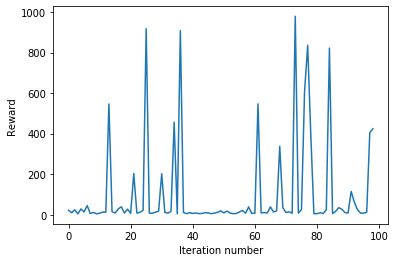

875 number games left
100.40146778821945 minutes taken
850 number games left
130.88921003341676 minutes taken
825 number games left
164.96069403886796 minutes taken
800 number games left
203.92165651718776 minutes taken


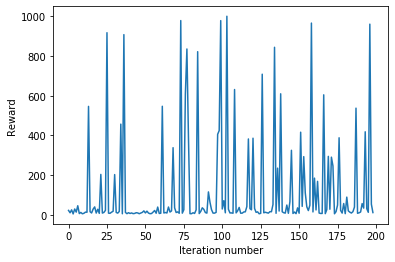

775 number games left
246.7118779182434 minutes taken
750 number games left
292.5646658817927 minutes taken
725 number games left
341.8495458086332 minutes taken
700 number games left
394.81780498425167 minutes taken


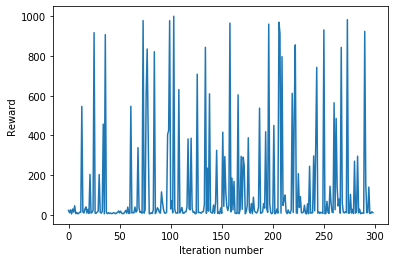

675 number games left
451.5405978679657 minutes taken
650 number games left
512.0157893220584 minutes taken
625 number games left
576.0347080548604 minutes taken
600 number games left
643.710265080134 minutes taken


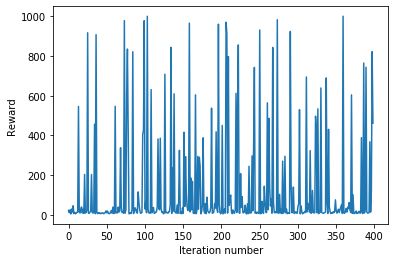

575 number games left
715.0515773455302 minutes taken
550 number games left
790.334541229407 minutes taken
525 number games left
869.3200085401535 minutes taken
500 number games left
951.9202950874965 minutes taken


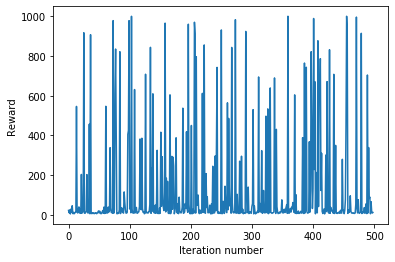

475 number games left
1038.6131145238876 minutes taken
450 number games left
1128.3765049378078 minutes taken
425 number games left
1223.142057478428 minutes taken
400 number games left
1335.7469734311103 minutes taken


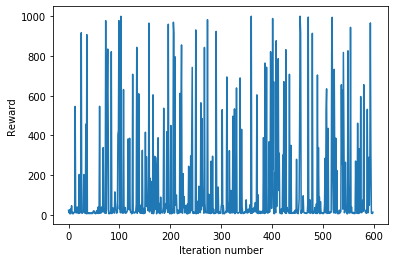

375 number games left
1441.7268268942832 minutes taken
350 number games left
1549.085521074136 minutes taken
325 number games left
1657.7044125596683 minutes taken
300 number games left
1768.2987606922786 minutes taken


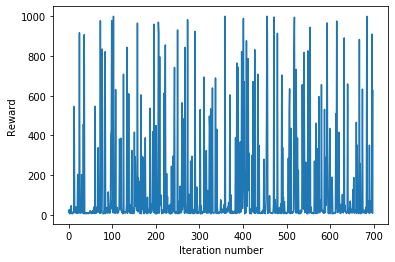

275 number games left
1882.7068625768027 minutes taken
250 number games left
2000.5803083936373 minutes taken
225 number games left
2122.2100106716157 minutes taken
200 number games left
2247.3796201030414 minutes taken


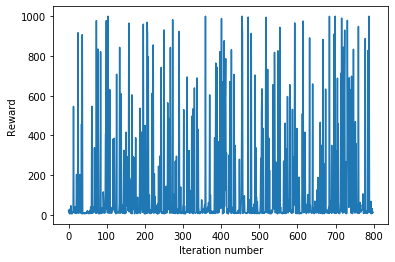

175 number games left
2376.6055034915607 minutes taken


PermissionError: [Errno 13] Permission denied: 'Swimmer6/scores.csv'

In [48]:
num_games = 1000

agent,scores, last_rewards, first_rewards = train_model(env, num_games, state_dim, action_spec)

In [65]:
from tensorflow.keras.models import load_model
# target_actor_model = load_model('Swimmer6/target_actor_model.h5')
target_actor_model = load_model('Swimmer-Copy-500/target_actor_model.h5')

In [59]:
from dm_control import suite
from dm_control import viewer
import numpy as np

env = suite.load(domain_name="swimmer", task_name="swimmer6",visualize_reward = True)
action_spec = env.action_spec()
obs_spec = env.observation_spec()

test_games_num = 100
test_scores = []

for game in range(test_games_num):
    score = 0
    step_data = env.reset()  # get initial state 
    obs = convert_state(step_data.observation)
    while not step_data.last():
#         action = np.random.uniform(low=action_spec.minimum,high=action_spec.maximum,size=action_spec.shape) 
        action = target_actor_model.predict(obs)
        step_data = env.step(action[0])
        obs = convert_state(step_data.observation)
        score += step_data.reward
    print(score)   
    test_scores.append(score)

print("Average reward on test 100 games: ", np.mean(test_scores))
    
#     for step in range(max_steps_in_game):
# #         env.render()  # show gif
# #         print(observation)  # print state vector 8, fixed for environment
#         obs = np.reshape(obs, (1, state_size))
#         rewards = trained_model.predict(obs)
#         action = int(np.argmax(rewards[0]))
# #         action = env.action_space.sample()
#         obs, reward, done, info = env.step(action)  # step returns 4 parameters
#         score +=reward
#         if done:  # game over need reset
# #             print("Episode finished after {} timesteps".format(step+1))
#             print(score)
#             break
#     test_scores.append(score)

54.87067859609553
9.774153810089539
105.4986080880982
312.23797446664247
3.5791223884367227
321.71489531893747
13.254593412162864
11.019055428101069
9.324569355966936
7.451129137180279
4.746572744073236
14.499425897048486
8.351226031122067
18.267620131150704
5.08261569893536
866.9232094168726
22.604634601787904
7.735114282915809
63.90130392588806
11.14838878601249
13.064081226920166
84.55662578880148
342.3385534919545
8.082088932903847
14.158001715273372
33.58199306794796
6.165797540065646
36.2324053250798
12.877669260670501
371.9294913662517
802.61149035342
7.874796783836533
6.313609453995436
731.9619982904326
18.066111233988924
9.896042092421114
9.158914897419699
457.629080860679
8.129702263526449
7.744457475000172
7.507775838672193
109.18943603682202
411.7404663964749
43.111162435889824
87.68069143704696
6.0658966445709
346.2862156461713
7.637712505241041
11.836786268868902
8.477841734971793
341.058447699886
6.744594454046663
5.559741306371251
14.966771494116571
7.747976525926192
33

In [ ]:
#Viewer
from dm_control import suite
from dm_control import viewer
import numpy as np

# env = suite.load(domain_name="humanoid", task_name="stand")
env = suite.load(domain_name="swimmer", task_name="swimmer6")
action_spec = env.action_spec()
print(action_spec)

# Define a uniform random policy.
def random_policy(time_step):
#     del time_step  # Unused.
#     print(target_actor_model.predict(convert_state(time_step)[0]))
    
    action = target_actor_model.predict(convert_state(time_step.observation))[0]
#     print(action)
    return action
# time_step = env.reset()

# Launch the viewer application.
viewer.launch(env, policy=random_policy)

BoundedArray(shape=(5,), dtype=dtype('float64'), name=None, minimum=[-1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1.])
